In [2]:
import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

from keras import utils
from sklearn.preprocessing import LabelEncoder

In [3]:
# dir_path points towards where to find the image dataset
dir_path = "brain_tumor_dataset"
IMAGE_SHAPE = (224, 224)
MUBA_ITERS = 20

random_sample = 1

# Read the folders folders
directories = os.listdir(dir_path)

files = [] 
labels = []

# Read files for each directory
for folder in directories:
    
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    labels.extend([folder for _ in fileList])
    files.extend(fileList)

len(files), len(labels)

(253, 253)

In [4]:
# One hot encoding

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y,dtype ="uint8", num_classes = 2)

labels = np.array(dummy_y)

print(f"Classes are {encoder.classes_}")

Classes are ['no' 'yes']


In [5]:
# Split the data into testing, training and validation data
# As using a random sample = 100, the testing set is the same as used for the model.
x_train, x_tv, y_train, y_tv = train_test_split(files, labels, test_size=.3, random_state = random_sample)
x_test, x_val, y_test, y_val = train_test_split(x_tv, y_tv, test_size=.5, random_state = random_sample)

In [6]:
images = []
labels = []

print("Preparing testing data")
for file, label in zip(x_test, y_test):

    # Prepare the image
    new_file = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(new_file)
    # Append to array
    images.append(img_array)
    labels.append(label)

Preparing testing data


In [7]:
model = keras.models.load_model("medium_model_2.h5")

In [8]:
basic_results = model.predict(np.stack(images))

2/2 [==============================] - 4s 454ms/step


In [9]:
initial_df = pd.DataFrame()
initial_df["class"] = [label[0] for label in labels]
initial_df["image_index"] = [i for i in range(len(images))]
initial_df["confidence_no"] = [alpha[0] for alpha in basic_results]

In [10]:
class_zero_df = initial_df[initial_df["class"] == 0]
class_one_df = initial_df[initial_df["class"] == 1]
class_one_length = len(class_one_df)

In [11]:
muba_df = pd.DataFrame(columns = ["class_0_confidence",
                    "class_1_confidence",
                    "alpha_no",
                    "image",
                    "y_value",
    ])

In [12]:
for index0, row0 in class_zero_df.iterrows():
    
    for index1, row1 in class_one_df.iterrows():

        for i in range(MUBA_ITERS):
            
            # Mixup images
            lam = (1/MUBA_ITERS) * np.random.rand() + ( (i) / MUBA_ITERS)
            new_img = lam * images[int(row0["image_index"])] + (1 - lam) * images[int(row1["image_index"])]

            row = {"class_0_confidence": row0["confidence_no"],
                    "class_1_confidence": row1["confidence_no"],
                    "alpha_no": lam,
                    "image": new_img,
                    "y_value": (row1["confidence_no"] - row0["confidence_no"]) * (lam) + row0["confidence_no"],
    
                    }
            
            muba_df = muba_df.append(row, ignore_index = True)


            




C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_8624\2973719742.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  muba_df = muba_df.append(row, ignore_index = True)
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_8624\2973719742.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  muba_df = muba_df.append(row, ignore_index = True)
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_8624\2973719742.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  muba_df = muba_df.append(row, ignore_index = True)
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_8624\2973719742.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  muba_df = m

(array([360., 358., 355., 357., 357., 355., 358., 357., 356., 356., 358.,
        356., 356., 359., 353., 360., 356., 356., 355., 362.]),
 array([3.63796402e-04, 5.03220646e-02, 1.00280333e-01, 1.50238601e-01,
        2.00196869e-01, 2.50155137e-01, 3.00113405e-01, 3.50071674e-01,
        4.00029942e-01, 4.49988210e-01, 4.99946478e-01, 5.49904746e-01,
        5.99863015e-01, 6.49821283e-01, 6.99779551e-01, 7.49737819e-01,
        7.99696087e-01, 8.49654355e-01, 8.99612624e-01, 9.49570892e-01,
        9.99529160e-01]),
 <BarContainer object of 20 artists>)

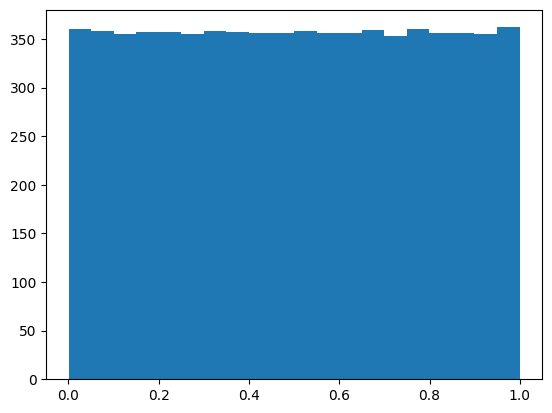

In [13]:
plt.hist(muba_df["alpha_no"], bins = 20)

In [14]:
# Get Predictions
result = model.predict(np.stack(muba_df["image"]))
pred_array = [np.argmax(individual_result) for individual_result in result] # 0 is no, 1 is yes

224/224 [==============================] - 491s 2s/step


Text(1.03, 0.5, "'No' Cluster")

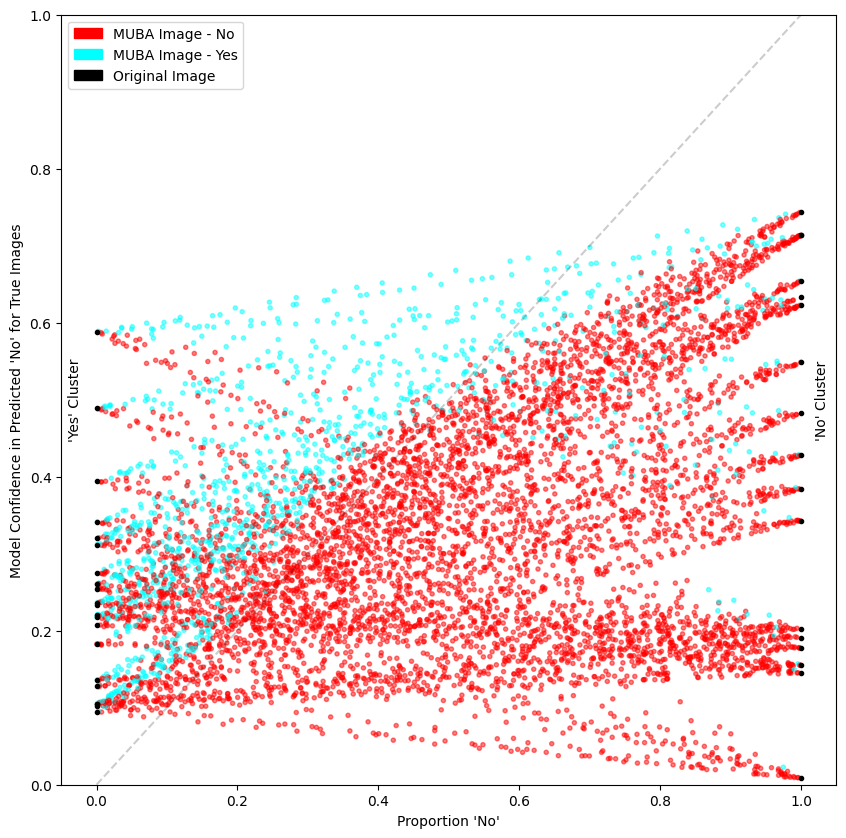

In [15]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)

ax.plot([0,1],[0,1], linestyle='--',color="black",alpha=0.2)
ax.scatter(muba_df["alpha_no"],muba_df["y_value"], marker = ".", alpha = 0.5, color = ["red" if x == 1 else "aqua" for x in pred_array], label = "Mixup Images")
ax.scatter(initial_df["class"],initial_df["confidence_no"], marker = ".", color = "black", label = "True Images")
ax.set_ylim([0,1])

# Create a legend with a color box
no_patch = mpatches.Patch(color='red', label='MUBA Image - No')
yes_patch = mpatches.Patch(color='aqua', label='MUBA Image - Yes')
original_patch = mpatches.Patch(color='black', label='Original Image')

ax.legend(handles=[no_patch, yes_patch, original_patch])

ax.set_xlabel("Proportion 'No'")
ax.set_ylabel("Model Confidence in Predicted 'No' for True Images")

#ax.plot([0,1],[0,0], linestyle = "--", color = "black", marker = "|")

# ax.text(0.5,-0.02,"Alpha Value", ha = "center")
# ax.text(0,-0.02,"0", ha = "center")
# ax.text(1,-0.02,"1", ha = "center")

ax.text(-0.03,0.5,"'Yes' Cluster", rotation = "vertical", va = "center", ha = "center")
ax.text(1.03,0.5,"'No' Cluster", rotation = "vertical", va = "center", ha = "center")

# ax.axis("off")


In [16]:
analysis_df = muba_df.drop('image',axis=1)

predictions = pd.DataFrame()
predictions["pred"] = pred_array

# Merge on predictions
analysis_df = analysis_df.join(predictions)
boundary_df = pd.DataFrame(columns = ["alpha","y"])

for i in range(int(len(analysis_df)/20)):
    # Create a mask to split df in to blocks of 20
    mask = (analysis_df.index >= 20*i) & (analysis_df.index < 20*i + 20)
    window_df = analysis_df.loc[mask]

    # Find the index in which the prediction changes
    changing_pred_index = (window_df["pred"].diff()[window_df["pred"].diff() != 0].index.values)
    for boundary in changing_pred_index[1:]: # If pred doesn't change will equal 1
        row0 = window_df[window_df.index == boundary-1]
        row1 = window_df[window_df.index == boundary]
        middle_alpha = row0["alpha_no"][boundary-1] + ((row1["alpha_no"][boundary] - row0["alpha_no"][boundary-1]) / 2 )
        middle_y = row0["y_value"][boundary-1] + ( (row1["y_value"][boundary] - row0["y_value"][boundary-1]) / 2 )
        new_row = {
            "alpha":middle_alpha,
            "y":middle_y
        }
        
        boundary_df = boundary_df.append(new_row, ignore_index = True)

C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_8624\613731109.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  boundary_df = boundary_df.append(new_row, ignore_index = True)
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_8624\613731109.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  boundary_df = boundary_df.append(new_row, ignore_index = True)
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_8624\613731109.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  boundary_df = boundary_df.append(new_row, ignore_index = True)
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_8624\613731109.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

In [75]:
incorrect_alphas = (analysis_df[analysis_df["pred"] == analysis_df["alpha_no"].round()])["alpha_no"]
# If alpha_no == 0.6, the prediction should be "no", which has a pred value of 0. You can round alpha_no to 1, which is the incorrect value.
# Must be incorrect if the rounded value = the pred value
incorrect_alphas

10      0.547829
11      0.580693
12      0.634940
13      0.665374
14      0.722533
          ...   
7135    0.752077
7136    0.805974
7137    0.880816
7138    0.948980
7139    0.988981
Name: alpha_no, Length: 4251, dtype: float64

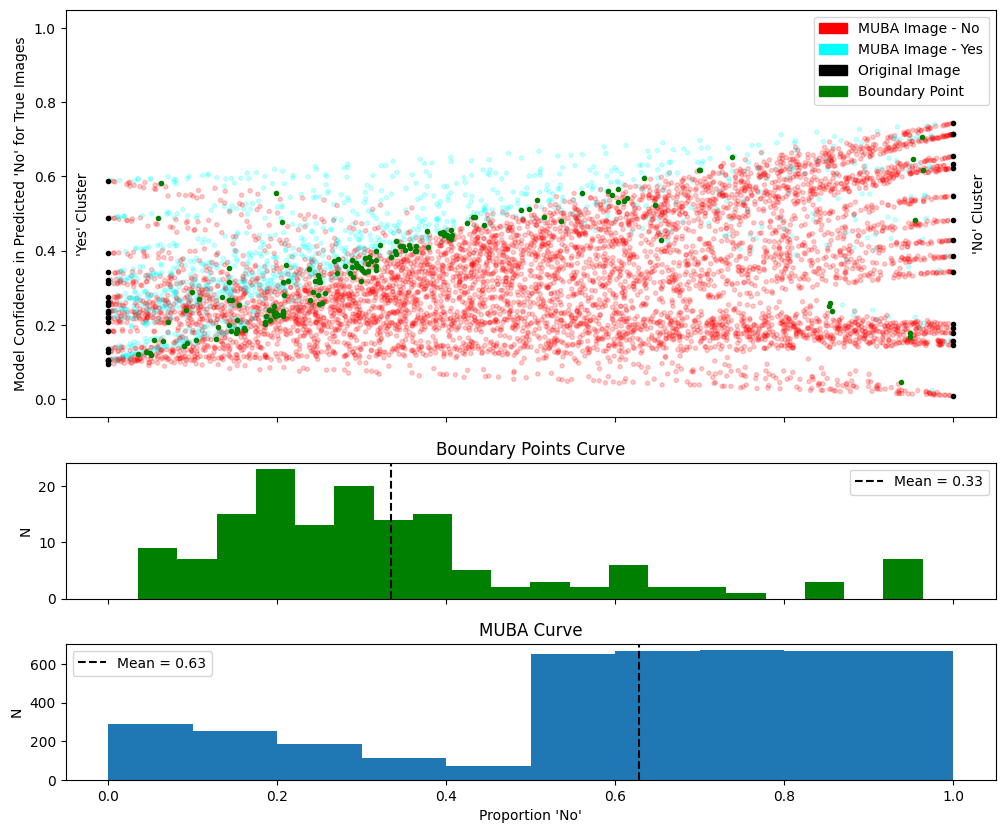

In [76]:
fig, ax = plt.subplots(3,1,gridspec_kw={'height_ratios': [3, 1,1]}, figsize = (12,10),sharex = True)
fig.subplots_adjust(hspace=0.2)

ax[0].scatter(muba_df["alpha_no"],muba_df["y_value"], marker = ".", alpha = 0.2, color = ["red" if x == 1 else "aqua" for x in pred_array], label = "Mixup Images")
ax[0].scatter(initial_df["class"],initial_df["confidence_no"], marker = ".", color = "black", label = "True Images")
ax[0].scatter(boundary_df["alpha"],boundary_df["y"], marker = ".", color = "green")
ax[0].set_ylim([-0.05,1.05])

# Create a legend with a color box
no_patch = mpatches.Patch(color='red', label='MUBA Image - No')
yes_patch = mpatches.Patch(color='aqua', label='MUBA Image - Yes')
original_patch = mpatches.Patch(color='black', label='Original Image')
middle_patch = mpatches.Patch(color='green', label='Boundary Point')

ax[0].legend(handles=[no_patch, yes_patch, original_patch, middle_patch])


ax[0].set_ylabel("Model Confidence in Predicted 'No' for True Images")
ax[0].text(-0.03,0.5,"'Yes' Cluster", rotation = "vertical", va = "center", ha = "center")
ax[0].text(1.03,0.5,"'No' Cluster", rotation = "vertical", va = "center", ha = "center")

# ax.axis("off")
ax[1].hist(boundary_df["alpha"],bins=20,color="green")
mean = np.mean(boundary_df["alpha"])
ax[1].axvline(mean, color = "black", linestyle = "--", label = f"Mean = {round(mean,2)}")
ax[1].set_ylabel("N")
ax[1].set_title("Boundary Points Curve")
ax[1].legend()

ax[2].hist(incorrect_alphas)
mean = np.mean(incorrect_alphas)
ax[2].axvline(mean, color = "black", linestyle = "--", label = f"Mean = {round(mean,2)}")
ax[2].set_xlabel("Proportion 'No'")
ax[2].set_ylabel("N")
ax[2].set_title("MUBA Curve")
ax[2].legend()